importing libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score,confusion_matrix,classification_report,roc_curve,auc,precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

import shap

pd.set_option("display.max_columns",None)

c:\Users\sahil kavishka\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load dataset

In [15]:
matches=pd.read_csv("all_champions_trophy_matches_results.csv")
players=pd.read_csv("all_champions_trophy_players_list.csv")

matches.head(),players.head()

(          Team1        Team2                                  Toss Match days  \
 0  South Africa  West Indies  South Africa, elected to field first   daynight   
 1         India  West Indies           India, elected to bat first   daynight   
 2  South Africa    Sri Lanka     Sri Lanka, elected to field first   daynight   
 3      Pakistan  West Indies     West Indies, elected to bat first   daynight   
 4     Australia        India     Australia, elected to field first   daynight   
 
          Winner Player of the Match     Margin Ground    Match Date  \
 0  South Africa      Jacques Kallis  4 wickets  Dhaka   Nov 1, 1998   
 1   West Indies       Mervyn Dillon  6 wickets  Dhaka  Oct 31, 1998   
 2  South Africa      Jacques Kallis    92 runs  Dhaka  Oct 30, 1998   
 3   West Indies     Keith Arthurton    30 runs  Dhaka  Oct 29, 1998   
 4         India    Sachin Tendulkar    44 runs  Dhaka  Oct 28, 1998   
 
   ODI Int Match  Team1 Avg Batting Ranking  Team2 Avg Batting Ranking  

data cleaning

In [18]:
#strip column name
matches.columns=matches.columns.str.strip()
players.columns=players.columns.str.strip()

#drop duplicates
matches.drop_duplicates(inplace=True)

#drop rows with missing value
matches=matches.dropna(subset=["Winner","Team1","Team2"])

#clean string fields
for col in ["Winner","Team1","Team2","Ground","Margin","Match Date","Toss","Match days"]:
    if col in matches.columns:
        matches[col]=matches[col].astype(str).str.strip()

#convert match date
matches["Date"]=pd.to_datetime(matches["Match Date"],format="%b %d, %y",errors="coerce")

matches.head()


,Team1,Team2,Toss,Match days,Winner,Player of the Match,Margin,Ground,Match Date,ODI Int Match,Team1 Avg Batting Ranking,Team2 Avg Batting Ranking,Team1 Avg Bowling Ranking,Team2 Avg Bowling Ranking,Team1 Total CTs participated,Team1 Total CTs won,Team2 Total CTs participated,Team2 Total CTs won,Team1 W/L ratio over Team2,Date
0,South Africa,West Indies,"South Africa, elected to field first",daynight,South Africa,Jacques Kallis,4 wickets,Dhaka,"Nov 1, 1998",ODI # 1364,66.58,63.42,81.50,84.92,0,0,0,0,1.000,NaT
1,India,West Indies,"India, elected to bat first",daynight,West Indies,Mervyn Dillon,6 wickets,Dhaka,"Oct 31, 1998",ODI # 1363,58.00,63.92,63.73,86.25,0,0,0,0,0.527,NaT
2,South Africa,Sri Lanka,"Sri Lanka, elected to field first",daynight,South Africa,Jacques Kallis,92 runs,Dhaka,"Oct 30, 1998",ODI # 1362,66.92,53.55,83.08,69.18,0,0,0,0,1.166,NaT
3,Pakistan,West Indies,"West Indies, elected to bat first",daynight,West Indies,Keith Arthurton,30 runs,Dhaka,"Oct 29, 1998",ODI # 1361,88.36,65.00,70.00,87.17,0,0,0,0,0.806,NaT
4,Australia,India,"Australia, elected to field first",daynight,India,Sachin Tendulkar,44 runs,Dhaka,"Oct 28, 1998",ODI # 1360,58.55,58.00,78.73,64.82,0,0,0,0,1.380,NaT


fuature engineering

In [19]:
# Extract toss winner and decision from Toss column
def parse_toss(t):
    t = str(t)
    if "," in t:
        parts = t.split(",", 1)
        winner = parts[0].strip()
        decision_part = parts[1].lower()
        if "bat" in decision_part:
            decision = "bat"
        elif "field" in decision_part or "bowl" in decision_part:
            decision = "field"
        else:
            decision = "unknown"
    else:
        winner = "unknown"
        decision = "unknown"
    return pd.Series([winner, decision])

matches[["Toss_Winner", "Toss_Decision"]] = matches["Toss"].apply(parse_toss)

# Is day-night match
matches["Is_DayNight"] = matches["Match days"].apply(
    lambda x: 1 if "night" in str(x).lower() else 0
)

# Parse margin: e.g. "4 wickets", "92 runs", "Tied", "no result"
def parse_margin(m):
    m = str(m).lower()
    runs, wkts = 0, 0
    tokens = m.split()
    if len(tokens) >= 2 and tokens[0].isdigit():
        num = int(tokens[0])
        if "run" in tokens[1]:
            runs = num
        elif "wicket" in tokens[1]:
            wkts = num
    return pd.Series([runs, wkts])

matches[["Win_By_Runs", "Win_By_Wickets"]] = matches["Margin"].apply(parse_margin)

def classify_win_type(r):
    if r["Win_By_Runs"] > 0:
        return "Runs"
    elif r["Win_By_Wickets"] > 0:
        return "Wickets"
    else:
        return "Other"

matches["Win_Type"] = matches.apply(classify_win_type, axis=1)

# Date features
matches["Year"] = matches["Date"].dt.year
matches["Month"] = matches["Date"].dt.month
matches["Day"] = matches["Date"].dt.day
matches["DayOfWeek"] = matches["Date"].dt.dayofweek

# Dominance metric
matches["Dominance"] = matches["Win_By_Runs"] + matches["Win_By_Wickets"] * 10

# Treat Ground as Venue
matches["Venue"] = matches["Ground"]
matches.head()


,Team1,Team2,Toss,Match days,Winner,Player of the Match,Margin,Ground,Match Date,ODI Int Match,Team1 Avg Batting Ranking,Team2 Avg Batting Ranking,Team1 Avg Bowling Ranking,Team2 Avg Bowling Ranking,Team1 Total CTs participated,Team1 Total CTs won,Team2 Total CTs participated,Team2 Total CTs won,Team1 W/L ratio over Team2,Date,Toss_Winner,Toss_Decision,Is_DayNight,Win_By_Runs,Win_By_Wickets,Win_Type,Year,Month,Day,DayOfWeek,Dominance,Venue
0,South Africa,West Indies,"South Africa, elected to field first",daynight,South Africa,Jacques Kallis,4 wickets,Dhaka,"Nov 1, 1998",ODI # 1364,66.58,63.42,81.50,84.92,0,0,0,0,1.000,NaT,South Africa,field,1,0,4,Wickets,NaN,NaN,NaN,NaN,40,Dhaka
1,India,West Indies,"India, elected to bat first",daynight,West Indies,Mervyn Dillon,6 wickets,Dhaka,"Oct 31, 1998",ODI # 1363,58.00,63.92,63.73,86.25,0,0,0,0,0.527,NaT,India,bat,1,0,6,Wickets,NaN,NaN,NaN,NaN,60,Dhaka
2,South Africa,Sri Lanka,"Sri Lanka, elected to field first",daynight,South Africa,Jacques Kallis,92 runs,Dhaka,"Oct 30, 1998",ODI # 1362,66.92,53.55,83.08,69.18,0,0,0,0,1.166,NaT,Sri Lanka,field,1,92,0,Runs,NaN,NaN,NaN,NaN,92,Dhaka
3,Pakistan,West Indies,"West Indies, elected to bat first",daynight,West Indies,Keith Arthurton,30 runs,Dhaka,"Oct 29, 1998",ODI # 1361,88.36,65.00,70.00,87.17,0,0,0,0,0.806,NaT,West Indies,bat,1,30,0,Runs,NaN,NaN,NaN,NaN,30,Dhaka
4,Australia,India,"Australia, elected to field first",daynight,India,Sachin Tendulkar,44 runs,Dhaka,"Oct 28, 1998",ODI # 1360,58.55,58.00,78.73,64.82,0,0,0,0,1.380,NaT,Australia,field,1,44,0,Runs,NaN,NaN,NaN,NaN,44,Dhaka


team statistics

In [20]:
teams = pd.concat([
    matches["Team1"],
    matches["Team2"],
    matches["Winner"]
]).dropna().unique()

stats = {}

for team in teams:
    mask_played = (matches["Team1"] == team) | (matches["Team2"] == team)
    mask_won = matches["Winner"] == team
    
    played = mask_played.sum()
    wins = mask_won.sum()
    losses = (mask_played & (~mask_won)).sum()
    win_rate = wins / played if played > 0 else 0
    avg_dom = matches.loc[mask_won, "Dominance"].mean()
    
    stats[team] = {
        "Matches_Played": played,
        "Wins": wins,
        "Losses": losses,
        "Win_Rate": win_rate,
        "Avg_Dominance": avg_dom
    }

team_stats_df = pd.DataFrame(stats).T.sort_values("Win_Rate", ascending=False)
team_stats_df.head()


,Matches_Played,Wins,Losses,Win_Rate,Avg_Dominance
India,34.0,23.0,11.0,0.676471,59.130435
West Indies,24.0,13.0,11.0,0.541667,54.384615
Sri Lanka,27.0,14.0,13.0,0.518519,79.285714
South Africa,27.0,14.0,13.0,0.518519,82.142857
New Zealand,29.0,15.0,14.0,0.517241,67.133333


team win rate plot

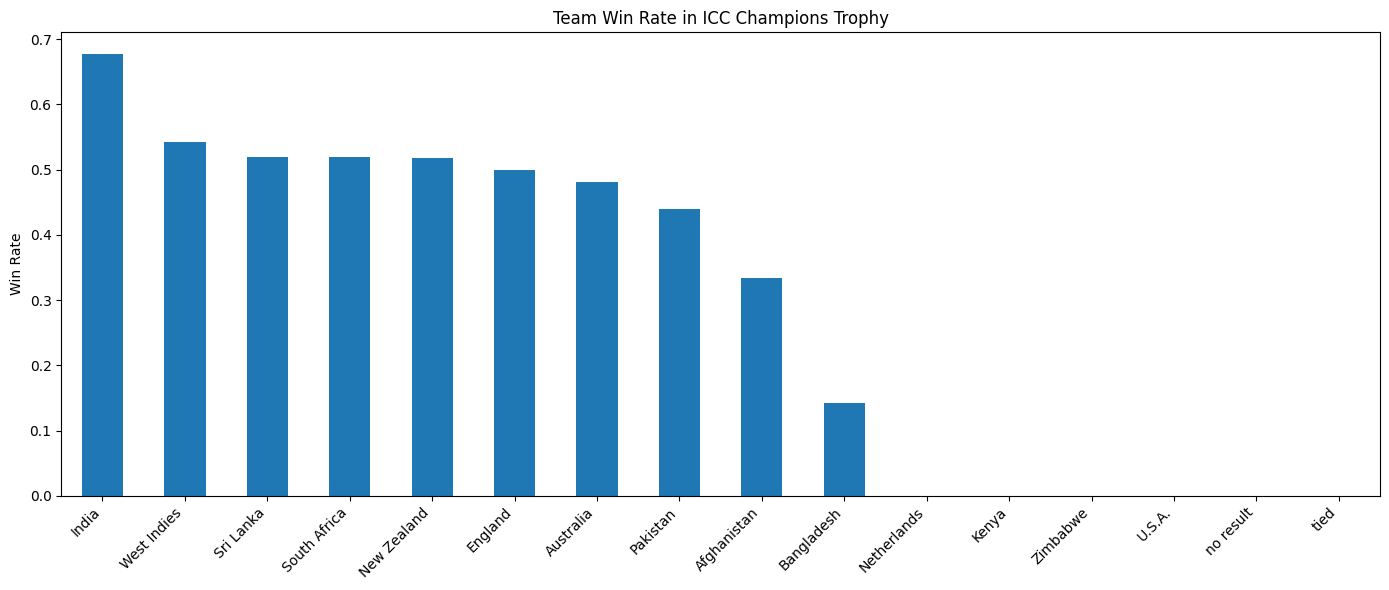

In [21]:
plt.figure(figsize=(14,6))
team_stats_df["Win_Rate"].sort_values(ascending=False).plot(kind="bar")
plt.title("Team Win Rate in ICC Champions Trophy")
plt.ylabel("Win Rate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


correlation heatmap

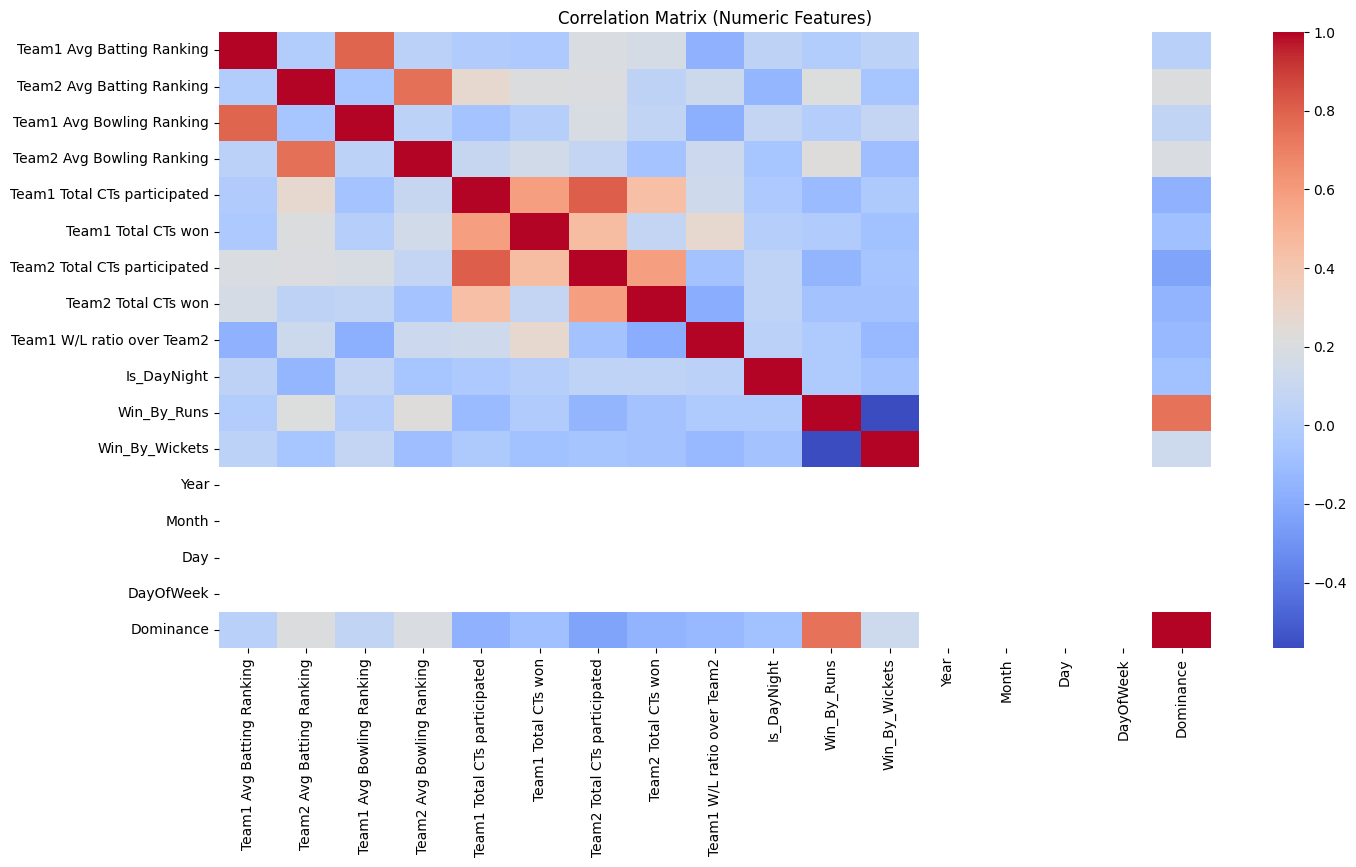

In [22]:
plt.figure(figsize=(16,8))
sns.heatmap(matches.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()


dominance between teams

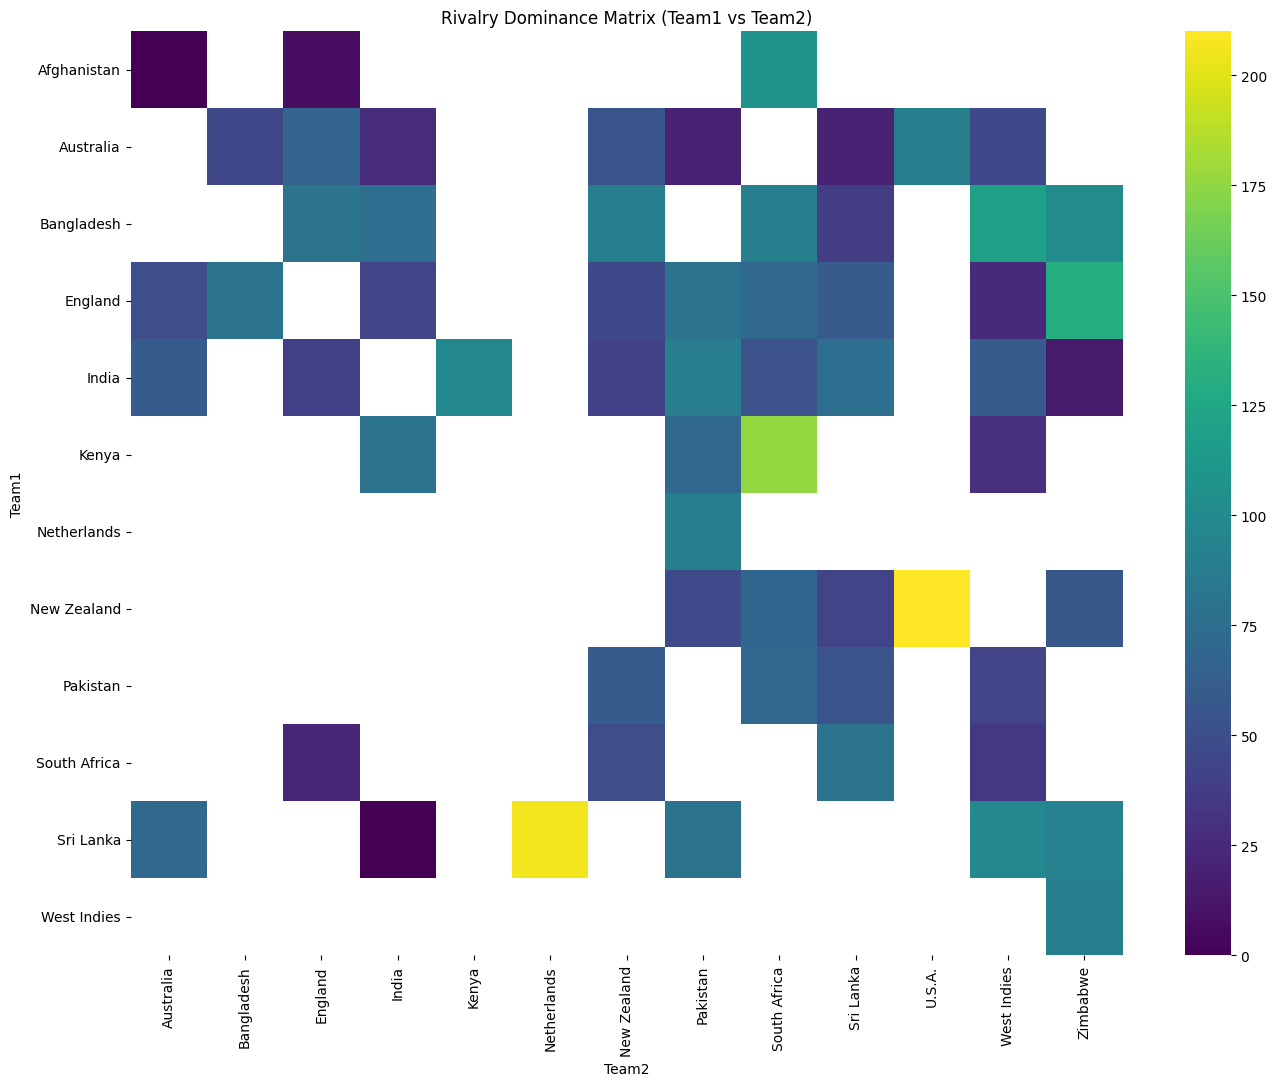

In [23]:
rivalry = pd.pivot_table(
    matches,
    index="Team1",
    columns="Team2",
    values="Dominance",
    aggfunc="mean"
)

plt.figure(figsize=(16,12))
sns.heatmap(rivalry, cmap="viridis")
plt.title("Rivalry Dominance Matrix (Team1 vs Team2)")
plt.ylabel("Team1")
plt.xlabel("Team2")
plt.show()


venue strength index

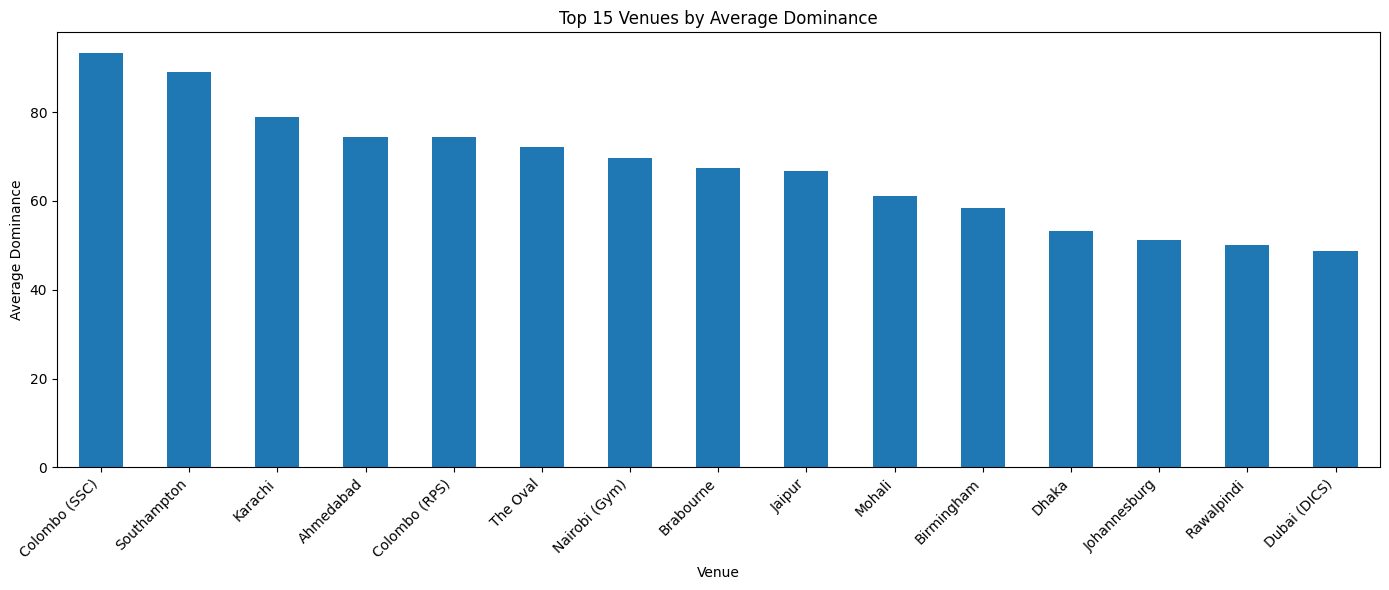

In [24]:
venue_strength = matches.groupby("Venue")["Dominance"].mean().sort_values(ascending=False)

plt.figure(figsize=(14,6))
venue_strength.head(15).plot(kind="bar")
plt.title("Top 15 Venues by Average Dominance")
plt.ylabel("Average Dominance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


toss impacton match winning

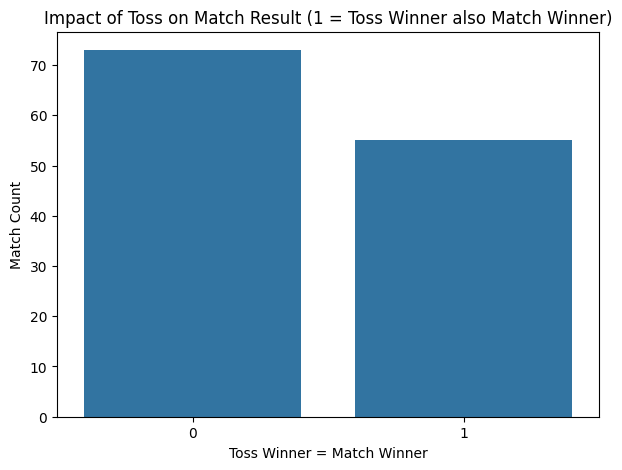

Toss winner also wins match: 42.97% of the time


In [25]:
toss_impact = (matches["Winner"] == matches["Toss_Winner"]).astype(int)

plt.figure(figsize=(7,5))
sns.countplot(x=toss_impact)
plt.title("Impact of Toss on Match Result (1 = Toss Winner also Match Winner)")
plt.xlabel("Toss Winner = Match Winner")
plt.ylabel("Match Count")
plt.show()

toss_win_rate = toss_impact.mean()
print(f"Toss winner also wins match: {toss_win_rate*100:.2f}% of the time")


machine learning - feature preparation

In [31]:
features = [
    "Team1", "Team2",
    "Toss_Winner", "Toss_Decision",
    "Venue",
    "Is_DayNight",
    "Year", "Month", "Day", "DayOfWeek"
]

df = matches.dropna(subset=["Winner"])

# Label encode categoricals
encoders = {}
for col in features + ["Winner"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

# Count how many times each team appears as Winner
win_counts = df["Winner"].value_counts()

# Keep only winners that appear at least 2 times
valid_winners = win_counts[win_counts >= 2].index
df_balanced = df[df["Winner"].isin(valid_winners)].copy()

X = df_balanced[features]
y = df_balanced["Winner"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


X_train.shape, X_test.shape


((94, 10), (32, 10))

random forest model

Random Forest Accuracy: 0.40625

Classification Report:

              precision    recall  f1-score   support

           1       0.40      0.67      0.50         3
           3       0.33      0.25      0.29         4
           4       0.56      0.83      0.67         6
           5       0.33      0.25      0.29         4
           6       0.33      0.33      0.33         3
           7       0.00      0.00      0.00         3
           8       1.00      0.25      0.40         4
           9       0.25      0.33      0.29         3
          10       1.00      0.50      0.67         2

    accuracy                           0.41        32
   macro avg       0.47      0.38      0.38        32
weighted avg       0.47      0.41      0.39        32



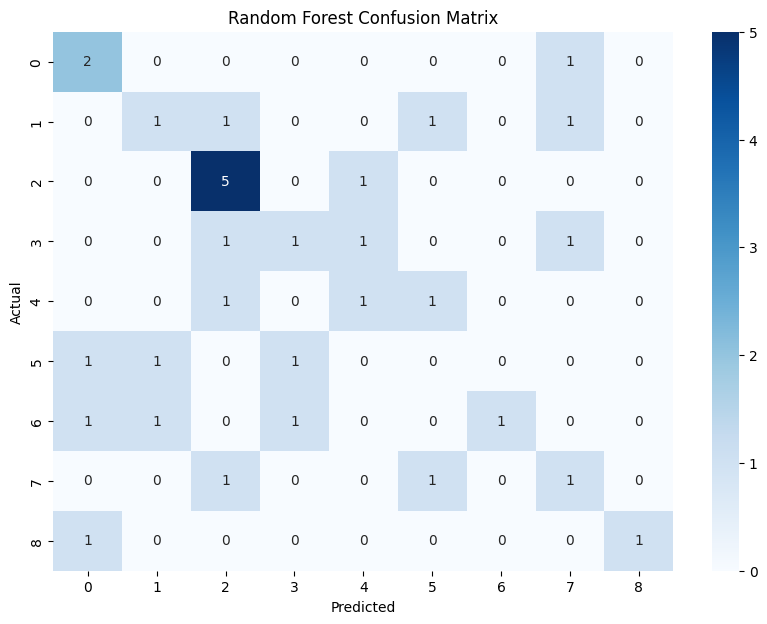

In [32]:
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, rf_pred))

cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


gradient boosting model

In [33]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_pred))


Gradient Boosting Accuracy: 0.5


roc curve

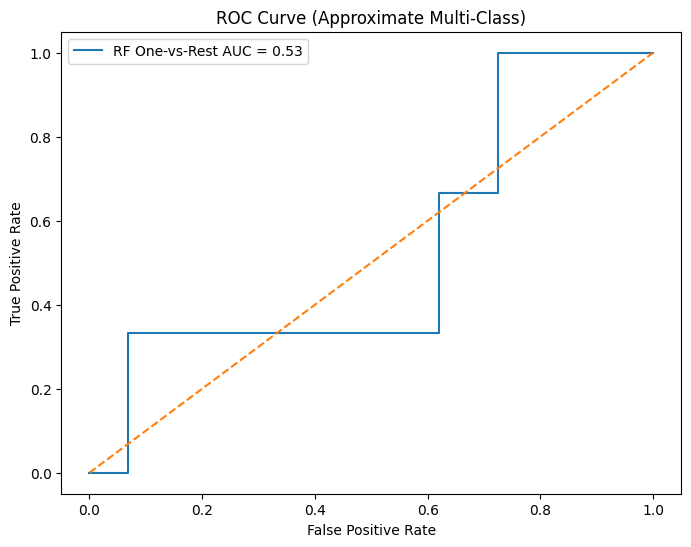

In [34]:
rf_probs = rf.predict_proba(X_test)
y_pred_class = rf_probs.argmax(axis=1)

fpr, tpr, _ = roc_curve((y_test == y_pred_class).astype(int), rf_probs.max(axis=1))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"RF One-vs-Rest AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve (Approximate Multi-Class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


precision-recall curve

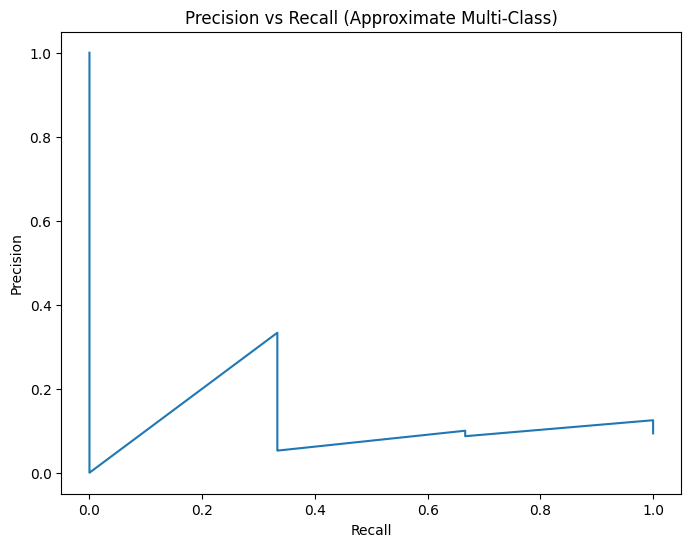

In [35]:
precision, recall, _ = precision_recall_curve(
    (y_test == y_pred_class).astype(int),
    rf_probs.max(axis=1)
)

plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.title("Precision vs Recall (Approximate Multi-Class)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


team clustering (KMeans)

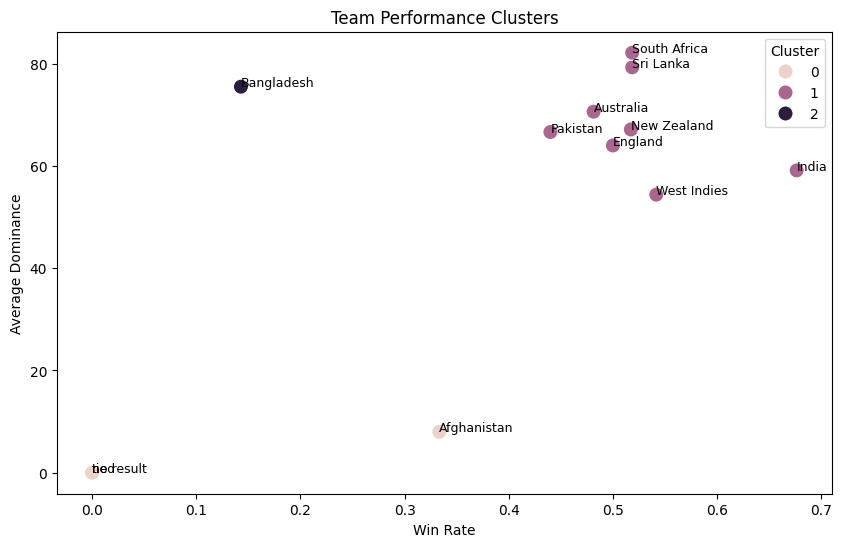

,Matches_Played,Wins,Losses,Win_Rate,Avg_Dominance,Cluster
India,34.0,23.0,11.0,0.676471,59.130435,1
West Indies,24.0,13.0,11.0,0.541667,54.384615,1
Sri Lanka,27.0,14.0,13.0,0.518519,79.285714,1
South Africa,27.0,14.0,13.0,0.518519,82.142857,1
New Zealand,29.0,15.0,14.0,0.517241,67.133333,1


In [36]:
team_matrix = team_stats_df[["Win_Rate", "Avg_Dominance"]].fillna(0)

scaler = StandardScaler()
scaled = scaler.fit_transform(team_matrix)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
team_stats_df["Cluster"] = kmeans.fit_predict(scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=team_stats_df["Win_Rate"],
    y=team_stats_df["Avg_Dominance"],
    hue=team_stats_df["Cluster"],
    s=120
)
plt.title("Team Performance Clusters")
plt.xlabel("Win Rate")
plt.ylabel("Average Dominance")
for team, row in team_stats_df.iterrows():
    plt.text(row["Win_Rate"], row["Avg_Dominance"], team, fontsize=9)
plt.show()

team_stats_df.head()


PCA-team map

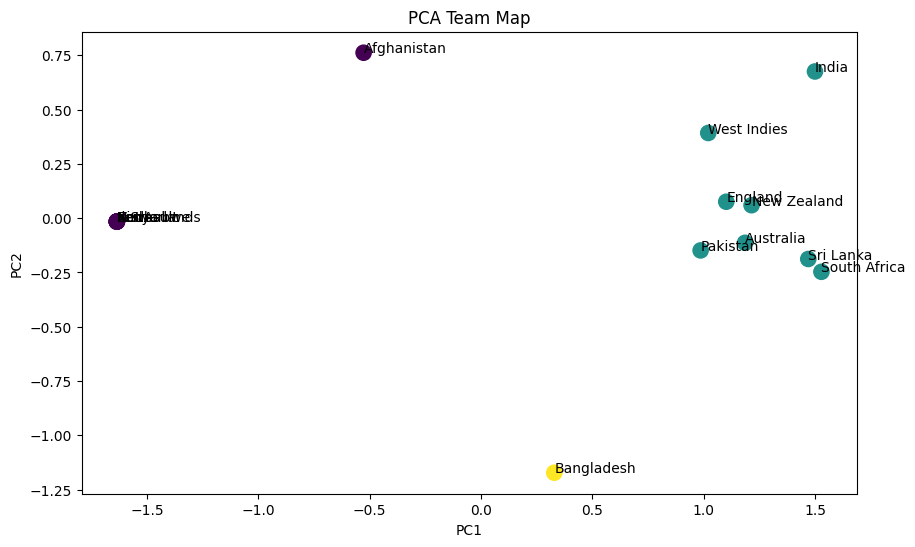

In [37]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled)

plt.figure(figsize=(10,6))
plt.scatter(pca_data[:,0], pca_data[:,1], c=team_stats_df["Cluster"], s=120)
for i, team in enumerate(team_stats_df.index):
    plt.text(pca_data[i,0], pca_data[i,1], team)
plt.title("PCA Team Map")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


shap interpretability

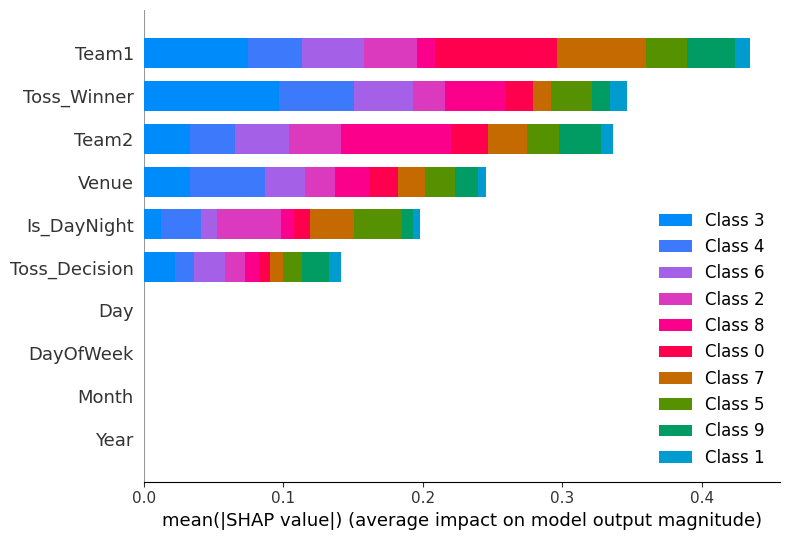

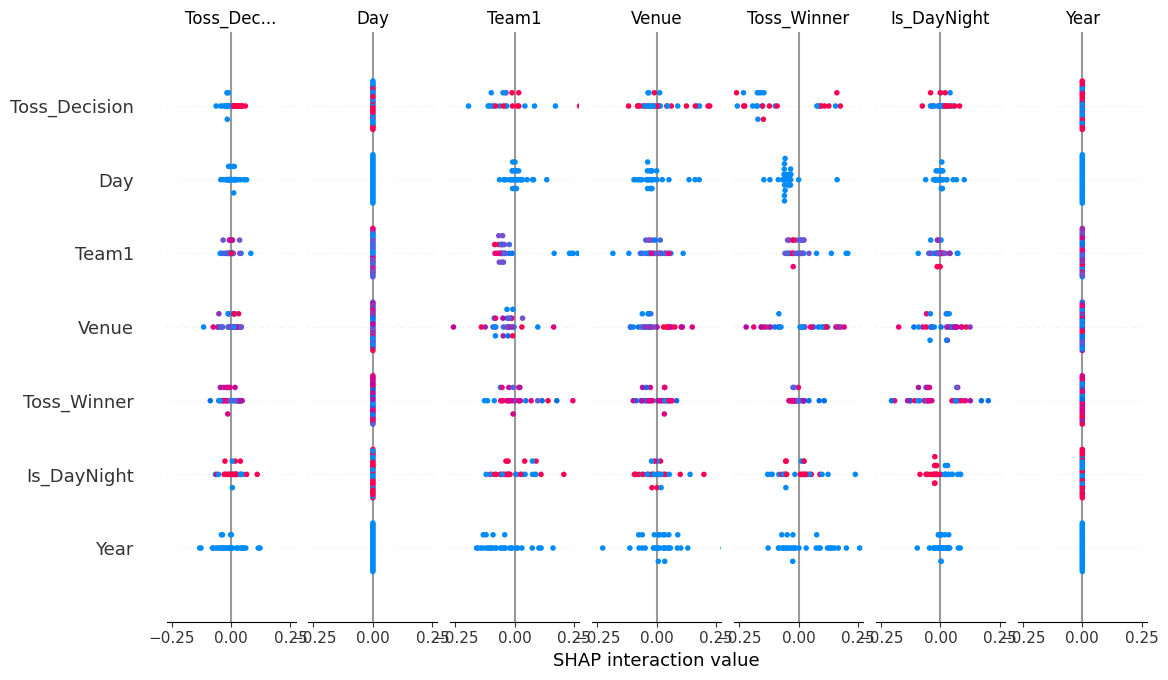

IndexError: index 10 is out of bounds for axis 0 with size 10

In [38]:
shap.initjs()

model_for_shap = rf
explainer = shap.TreeExplainer(model_for_shap)
shap_values = explainer.shap_values(X_test)

# Global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

# Dependence on Team1 encoding
shap.dependence_plot("Team1", shap_values[0], X_test)

# Force & Waterfall for a single prediction (class 0)
index = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][index], X_test.iloc[index])
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[0], shap_values[0][index], X_test.iloc[index]
)
